In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2

import sys
sys.path.append('../')
from Utils import utils_nn as utlnn

In [2]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")
# Se Verificó que las alturas comienzan desde R0 si el valor inicial es 6.371E6 estamos con R0 incluido.
# Tenemos que quitar ese R0 inicial de las alturas para el entrenamiento y para evitar alturas negativas aplicamos modulo.

In [4]:
# De mi y_train y y_test solo quiero las coordenadas Z
R0 = 6.371E6
out_z_coord = [f'alt_{i}' for i in range(1,201)]
y_train_z = y_train[out_z_coord] - R0
y_test_z = y_test[out_z_coord] - R0 
# 'y_test_z son las columnas filtradas de las 3 coordenadas'
y_train_z = y_train_z.abs()
y_test_z = y_test_z.abs()

In [5]:
from pandas.api.types import is_numeric_dtype

def info_dataset(df, name):
	print(f"Información Min-Max del dataframe: {name}:{df.shape}")	
	for i, col_name in enumerate(df.columns):
		col = df[col_name]
		# si no es numerica la ignoro, como lo hace ella conmigo.
		if not is_numeric_dtype(col):
			print(f"Columna {i} ({col_name}) no es numerica, se ignora.")
			continue
		print(f"Columna {i} ({col_name}): min={col.min():.4f}, max={col.max():.4f}, mean={col.mean():.4f}, std={col.std():.4f}")

# Gracias a la función pude observar una anomalía en los datos de y_train_z, que puede ser resuelta con un simple preprocesamiento.
# Alturas negativas no tienen sentido en este contexto.
# info_dataset(y_train_z, "y_train_z")
# Quitamos del train test xq year no varia, mmdd pasa en forma de sen y cos, hour igualmente
def drop_unnecessary_columns(x_train, x_test):
	x_train = x_train.drop(columns = ['year', 'mmdd_modified', 'mmdd','day_of_year', 'hour'])
	x_test = x_test.drop(columns =['year', 'mmdd_modified', 'mmdd','day_of_year', 'hour'])
	return x_train, x_test
x_train, x_test = drop_unnecessary_columns(x_train, x_test)


De toda la Información anterior observo que las columnas como.
latitude_pos_tx: -42.28 (valor único y constante)
longitude_pos_tx: -63.40 (valor único y constante)
elevation_pos_tx: 0.0 (valor único y constante)
year: 2010 (valor único y constante)

Estas 4 columnas tienen desviacion estándar 0, es decir, no aportan nada al aprendizaje del modelo.\
**Nota**: Los modelos de ML aprenden de las variaciones, y esas columnas no tienen ninguna.\
Procedemos a quitarlos del x_train/test

In [6]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['fc', 'elevation','azimuth']
scaler = StandardScaler()
scaler.fit(x_train[cols_to_scale])

x_train[cols_to_scale] = scaler.transform(x_train[cols_to_scale])
x_test[cols_to_scale] = scaler.transform(x_test[cols_to_scale])

import joblib
#Normalizamos la salida
from sklearn.preprocessing import MinMaxScaler

scaler_z = MinMaxScaler()
scaler_z.fit(y_train_z)
y_train_z_scaled = scaler_z.transform(y_train_z)
y_test_z_scaled = scaler_z.transform(y_test_z)

# 1. Guardado de Scalers 
joblib.dump(scaler, '../Scalers_Models/scaler_inputs.pkl')
joblib.dump(scaler_z, '../Scalers_Models/scaler_outputs_z.pkl')


['../Scalers_Models/scaler_outputs_z.pkl']

In [7]:
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(
  monitor = 'val_loss',	#monitoriamos la pérdida en validación
  patience = 30, # Si no mejora en 10->20 epochs, detenemos el entrenamiento.
  restore_best_weights = True # Restaura los mejores pesos encontrados.
)
reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  patience = 20,
  factor = 0.5
)
act_name = "relu"
l2_reg = 0.0007
epoch = 700
b_s= 64
optimizer_name = Adam(learning_rate = 1e-3)

# DNN - REGRESION MLP - 
def train_model(x_train,y_train_z_scaled):
  """
  Función para entrenar el modelo de la coordenada Z.
	
	Arguments:
	- x_train: datos de entrada para el entrenamiento.
	- y_train_z_scaled: datos de salida (coordenada Z) para el entrenamiento
  Returns:
	- modelo entrenado.
  - history: historial del entrenamiento.
  """
  inputs = Input(shape=(x_train.shape[1],))
  x = Dense(300, activation= act_name, kernel_regularizer= l2(l2_reg))(inputs)
  x = Dense(300, activation= act_name, kernel_regularizer= l2(l2_reg))(x)
  x = Dense(300, activation=act_name, kernel_regularizer=l2(l2_reg))(x)
  x = Dense(300, activation=act_name, kernel_regularizer=l2(l2_reg))(x)
  outputs = Dense(200, activation= 'linear', kernel_regularizer= l2(l2_reg), name ='z_output')(x)

  model = Model(inputs, outputs, name = 'altitude_predictor_mlp')
  model.compile(optimizer = optimizer_name, loss= 'mae') 
  model.summary()

  history = model.fit(x_train,y_train_z_scaled,
															epochs = epoch,
															batch_size = b_s,
															validation_split = 0.2,
															callbacks = [reduce_lr, early_stopping]
															)
  return model,history
model_z, history_z = train_model(x_train,y_train_z_scaled)

Model: "altitude_predictor_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 200)            │        60,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,500 (1.27 MB)

 Trainable params: 333,500 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4036 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 2/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0776 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 3/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0661 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 4/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0634 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 5/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0612 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 6/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0599 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 7/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0601 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 8/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 9/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0592 - val_loss: 0.0612 - learning_rate: 0.0010
E

Nota: si los batch_size son muy grandes es decir la actualización de los pesos por lotes. no finaliza la cantidad de epochs ya sea xq el learning rate es muy bajo o por que el early stopping detiene el entrenamiento por falta de mejora 


In [8]:
loss = model_z.evaluate(x_test,y_test_z_scaled)
print(f'Pérdida en datos de Test: {loss}')

# mae_in_m = loss[1]*R0
# print(f'mae:{mae_in_m}[m]')

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0530
Pérdida en datos de Test: 0.053476445376873016


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


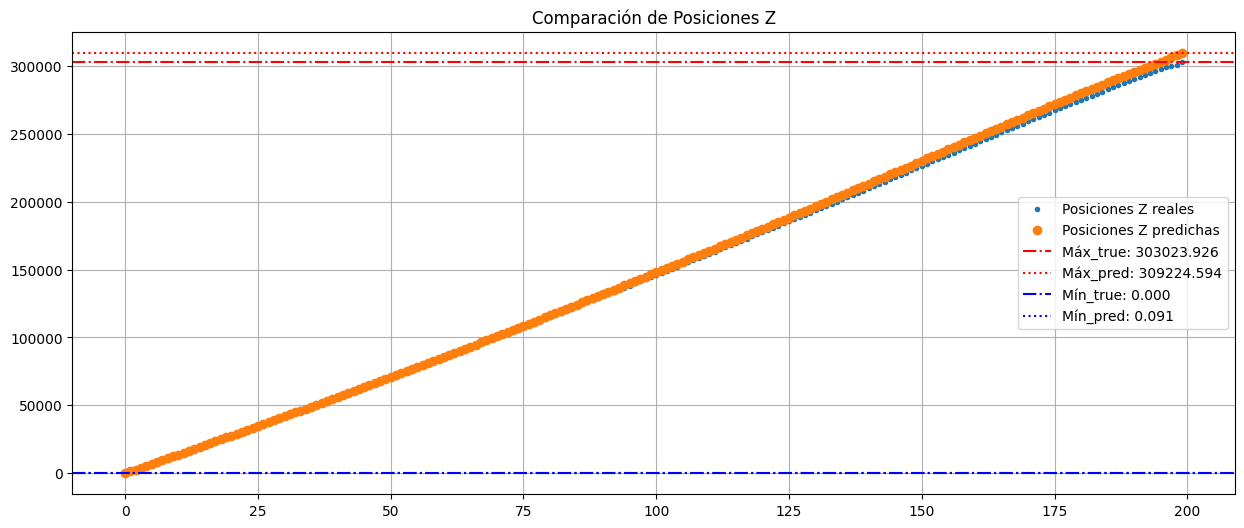

In [12]:
idx = 0
# Elegir una muestra para comparar.

y_pred_scaled = model_z.predict(np.expand_dims(x_test.iloc[idx], axis=0))

y_true = y_test_z.iloc[idx] # Se obtine Algo de tipo Serie
y_true=y_true.to_numpy() # Transform a Numpy array

#Desnormalizamos
y_pred = scaler_z.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten() # [[...,...,...,....,]]


def graf_1D(y_true,y_pred):
  ##Graficamos 
  # Buscamos los máximos y mínimos 
  y_true_max = np.max(y_true)
  y_true_min = np.min(y_true)

  y_pred_max = np.max(y_pred)
  y_pred_min = np.min(y_pred)

  # Pos z
  plt.figure(figsize=(15, 6))
  plt.plot(y_true, label='Posiciones Z reales', linestyle='None', marker='.')
  plt.plot(y_pred, label='Posiciones Z predichas', linestyle = 'None',marker='o')
  # Dibujamos los max y min
  plt.axhline(y = y_true_max, color = 'red', linestyle = '-.', label=f'Máx_true: {y_true_max:.3f}')
  plt.axhline(y = y_pred_max, color = 'red', linestyle = ':', label= f'Máx_pred: {y_pred_max:.3f}')
  plt.axhline(y = y_true_min, color = 'blue', linestyle ='-.', label=f'Mín_true: {y_true_min:.3f}')
  plt.axhline(y = y_pred_min, color = 'blue', linestyle = ':',label= f'Mín_pred:{y_pred_min: .3f}')

  # plt.ylim(-35,-50) ##(-60,-30)
  plt.title('Comparación de Posiciones Z')
  plt.legend()
  plt.grid(True)
  plt.show()
graf_1D(y_true,y_pred)

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

 --RESULTADOS DE LA EVALUACIÓN--
MAE (Error Medio Absoluto): 5628.1893 metros
RMSE (Raíz del Error Cuadrático Medio): 14027.0311 metros
R2 Score (Coeficiente de Determinación): 0.9212(Ideal es cercano a 1.0)


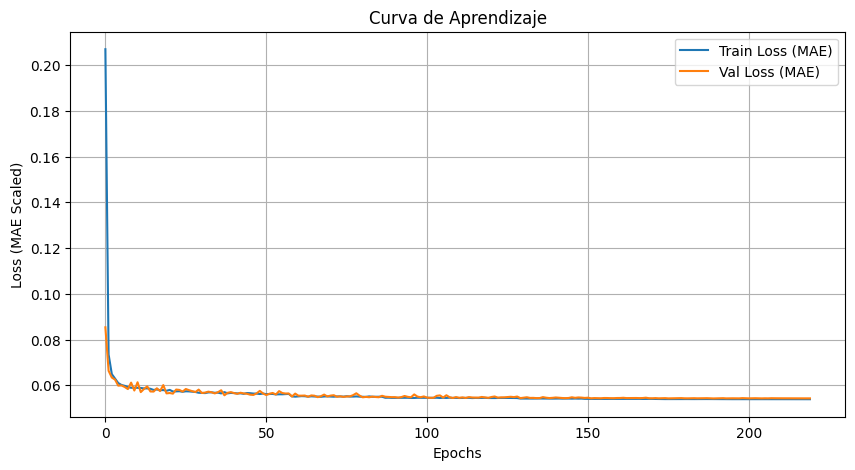

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
# Generamos predicciones
y_pred_scaled = model_z.predict(x_test)
# Inversa del Scaler
y_pred_real = scaler_z.inverse_transform(y_pred_scaled)
y_test_real = scaler_z.inverse_transform(y_test_z_scaled) # NO NECESARIO
# Cálculo de Métricas globales
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred_real)
# Métricas Globales
print(f'\n --RESULTADOS DE LA EVALUACIÓN--')
print(f'MAE (Error Medio Absoluto): {mae:.4f} metros')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f} metros')
print(f'R2 Score (Coeficiente de Determinación): {r2:.4f}(Ideal es cercano a 1.0)')
# Graf. Diagnóstico
plt.figure(figsize=(10, 5))
plt.plot(history_z.history['loss'], label='Train Loss (MAE)')
plt.plot(history_z.history['val_loss'], label ='Val Loss (MAE)')
plt.title('Curva de Aprendizaje')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE Scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Comparamos de manera Visual distintos Perfiles.
# Tomamemos 3 muetras aleatorias del set de test y comparamos la curva real vs predict 
num_samples_to_plot =  3
indices = np.random.choice(len(y_test_real, num_samples_to_plot, replace = False))
for i in indices :
  plt.figure(y_test_real[i], label = 'Real (Target)', color = 'blue', linewidth = 2)
  plt.plot(y_pred_real[i], label = 'Predicción', color= 'red', linestyle = '--', linewidth = 2)
  plt.title(f'Comparación de Perfil de Altura - Muestra #{i}')
  plt.xlabel('Puntos del Perfil (Indices 1-200)')
  plt.ylabel('Altura Z (Metros)')
  plt.legend()
  plt.grid(True, alpha = 0.3)
  plt.show()

In [ ]:
# #Guardado de Modelo.
# autoencoder_z.save("../modelos_entrenamiento/mod_z_R0/modelo2/modelo2.keras")

# #Guardado de Scaler
# import pickle
# with open('../modelos_entrenamiento/mod_z_R0/modelo2/scaler_z2.pkl','wb') as f:
#   pickle.dump(scaler_z,f)